### Importamos librerias

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import normaltest
from scipy.stats.mstats import normaltest #D'Agostino K^2 Test
from scipy.stats import boxcox
from scipy.special import inv_boxcox


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



%matplotlib inline
sns.set_theme(rc={"figure.figsize": [15,5]},
              style='dark')
sns.set_context(context='notebook')
plt.style.use('dark_background')

### Loading the Boston Housing Data


In [125]:
# !wet  para obtener los datos
# !wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

In [126]:
# Formato pickle rb = lectura binaria
with open('boston_housing_clean.pickle', 'rb') as to_read:
    boston = pd.read_pickle(to_read)
boston_data = boston['dataframe']
boston_description = boston['description']

In [127]:
boston_data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Determinar la normalidad

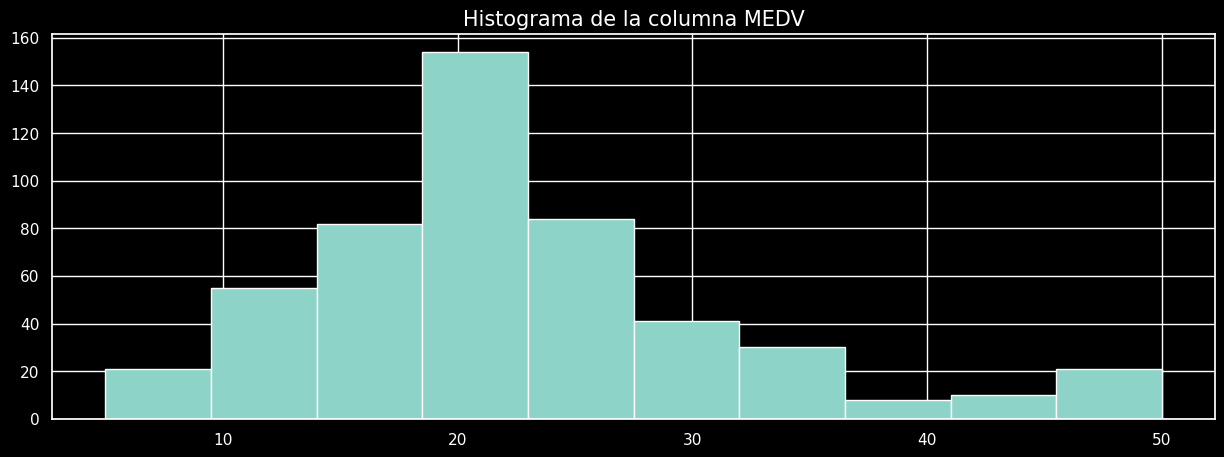

In [128]:
# Determinamos la normalidad de la variable objetivo (MEDV)
boston_data.MEDV.hist()
plt.title("Histograma de la columna MEDV", fontsize=15)
plt.show()

A simple vista en la figura se observa que no tiene una distribución normal;ademas,p-value is extremely low. Our y variable which we have been dealing with this whole time was not normally distributed!



In [129]:
# p-value > 0.5 para D.N
normaltest(boston_data.MEDV.values)

NormaltestResult(statistic=90.9746873700967, pvalue=1.7583188871696095e-20)

### Apply transformation to Boston Housing data: 

In [130]:
# Metodo 1: Aplicando log
log_medv = np.log(boston_data.MEDV)

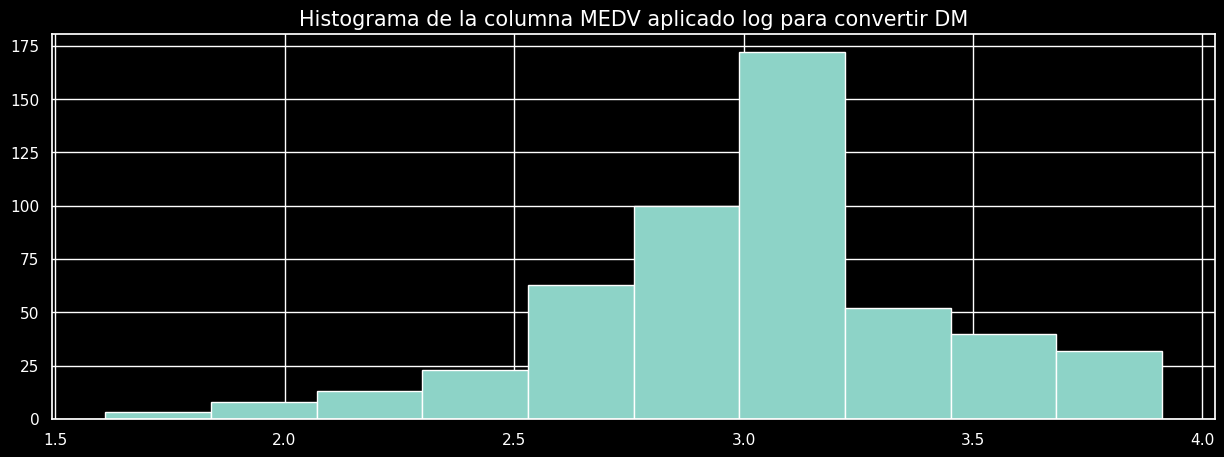

In [131]:
log_medv.hist()
plt.title("Histograma de la columna MEDV aplicado log para convertir DM", fontsize=15)
plt.show()

In [132]:
normaltest(log_medv)

NormaltestResult(statistic=17.21801696640698, pvalue=0.00018245472768345196)

Conclusion: The output is closer to normal distribution, but still not completely normal.



### Square root transformation

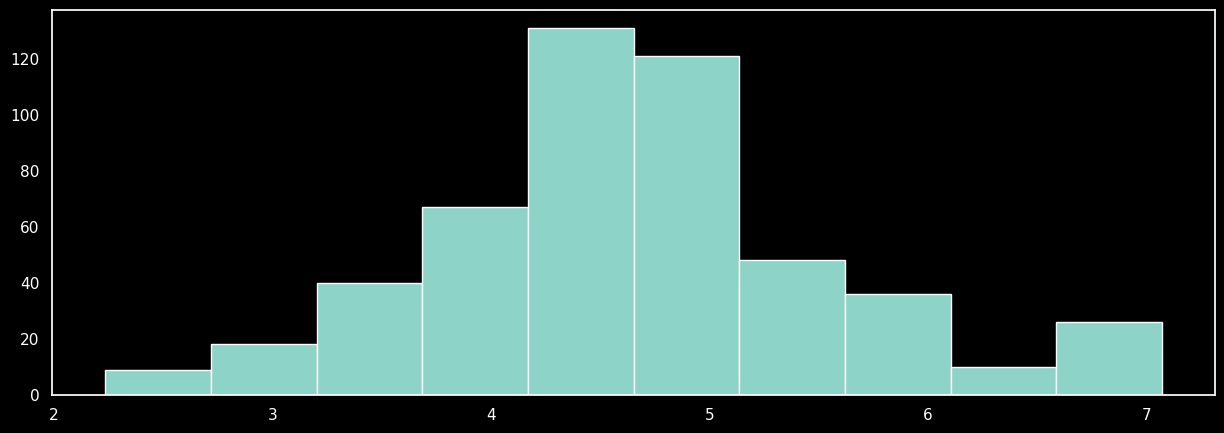

In [133]:
# Método 2: Aplicado SQR
sqrt_medv = np.sqrt(boston_data.MEDV)
plt.hist(sqrt_medv)
plt.show()

In [134]:
normaltest(sqrt_medv)

NormaltestResult(statistic=20.487090826863067, pvalue=3.558645701429252e-05)

### Box Cox Transformation

In [135]:
# Metodo 3: BOX COX
bc_result = boxcox(boston_data.MEDV)
boxcox_medv = bc_result[0]
lam = bc_result[1]

print(lam)

0.21662090066621686


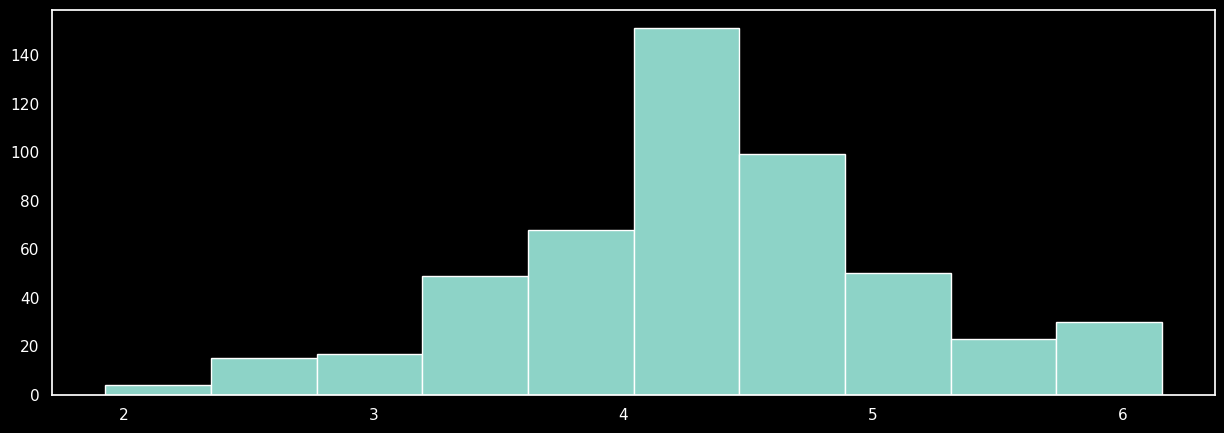

In [136]:
plt.hist(boxcox_medv)
plt.show()

In [137]:
normaltest(boxcox_medv)

NormaltestResult(statistic=4.513528777459214, pvalue=0.10468866918093613)

We find that the box cox results in a graph which is significantly more normally distributed (according to p value) than the other two distributions.This can be even above 0.05.



### Testing Regression

In [138]:
lr = LinearRegression()

In [139]:
# Define x and target variable(y)
y_col = 'MEDV'
X = boston_data.drop(y_col, axis=1)
y = boston_data[y_col]

In [140]:
# Create polynomal features to improve lineal regression
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

In [141]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3,
                                                    random_state=72018)

In [142]:
# Normalize the training data using StandarScaler on X_train. Use fit_transform()
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

In [143]:
# fit regression
lr.fit(X_train_s,y_train)

LinearRegression()

In [144]:
# Predict
lr_pred = lr.predict(X_test_s)
r_lineal = r2_score(y_test, lr_pred)
r_lineal

0.8689110469231016

### Applying inverse transformation boxcox on target variable (y)

In [145]:
# Apply the appropriate transformation
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

y_train_bc.shape

(354,)

In [146]:
# fit X_trains and y_train_bc and then predict_bc
lr.fit(X_train_s, y_train_bc)
y_pred_bc = lr.predict(X_test_s)

In [147]:
# Apply inverse transformation to be able to use these in a Regression context
inv_boxcox(boxcox_medv, lam)[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [148]:
boston_data['MEDV'].values[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

Exactly the same, as we would hope!



In [150]:
#Hint: use the inv_boxcox() function to get the transformed predicted values
y_pred_tran = inv_boxcox(y_pred_bc, lam2)
r_lineal_boxcox = r2_score(y_test, y_pred_tran)
r_lineal_boxcox

0.8884878245852588

In [151]:
results = {'LR' : r_lineal,
           'LR Box-cox' : r_lineal_boxcox}

df_comp = pd.DataFrame(results, index=['R²_score'])
df_comp

,LR,LR Box-cox
R²_score,0.868911,0.888488
